Team mates:

    Emerson Lopes Machado
    bmi.machado@gmail.com

    Eric Nesi
    nesi.eric@gmail.com

    Tom Croshaw
    tom.croshaw@gmail.com

    Greg Carrigan
    gregcarrigan@hotmail.com 

# Team FIFA

---

You are working for an advertising analytics consulting company.  Your client, a name brand television network, needs help deciding how to re-formulate the pricing structure for new customers, but also incentivize existing clients to convert to new partnerships sponsors for teams and players.

**Goals:**
- Determine a reasonable metric to decide how exciting a game is
    - Engineer this feature using existing data
- Suggest a pricing structure tied to the overall value associated with "game excitement"

**Presentation requirements:**
- At least 50% of presentation must address a non-technical audience
- Someone who hasn't presented in class yet must take lead on presentation

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

df = pd.read_csv("./datasets/fifa_goals.csv")

In [88]:
df.head()

,game_id,minute,player,team1score,team2score
0,1,18,Schiavio,1,0
1,1,20,Orsi,2,0
2,1,29,Schiavio,3,0
3,1,57,Donelli,3,1
4,1,63,Ferrari,4,1


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Data columns (total 5 columns):
game_id       2207 non-null int64
minute        2207 non-null object
player        2207 non-null object
team1score    2207 non-null int64
team2score    2207 non-null int64
dtypes: int64(3), object(2)
memory usage: 86.3+ KB


In [90]:
# Some cleanup
if df.minute.dtype != 'int64':
    df.loc[df.minute == '45+', 'minute'] = 45
    df.loc[df.minute == '90+', 'minute'] = 90
    df.loc[df.minute == '120+', 'minute'] = 121
    df.minute = pd.to_numeric(df.minute)

In [91]:
# Feature engineering

df['half'] = [1 if m <= 45 else 2 if m > 45 and m <= 90 else 3 for m in df.minute]
df['minute_half'] = df.minute - (df.half - 1) * 45

# The lower the goal difference is the more exciting is the match
goal_diff = np.abs(df.team1score - df.team2score)
df['excitement_per_goal'] = 1 / (goal_diff + 1)

# The higher the minute inside a half is the more exciting is the match
# Note that we give a very heavy weight to the time the goal is scored
# using the exponential function
df.excitement_per_goal =  df.excitement_per_goal * np.exp(df.minute_half/45)

# The excitement increases as the halfs go by
df.excitement_per_goal = df.excitement_per_goal * df.half

df_exct = df.groupby(df.game_id)

Let's see how our excitement factor is distributed when summed for each match.

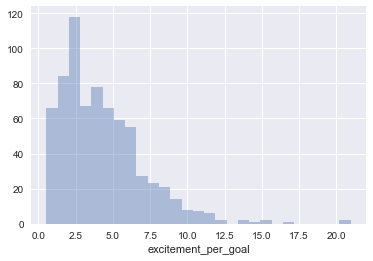

In [92]:
df_exct_total = df_exct.excitement_per_goal.sum()
sns.distplot(df_exct_total, kde=False);

Interesting to see that the distribution is left skewed, which means that most of mathes are boring :)

### Most Exciting Match

Let's take a quick look through the best match. Check how each goal marked by both teams have different excitement level.

In [93]:
best_goals_ids = df_exct.excitement_per_goal.sum().sort_values(ascending=False).index
best_match_columns = ['team1score', 'team2score', 'minute', 'excitement_per_goal']
df[df.game_id == best_goals_ids[0]][best_match_columns]

,team1score,team2score,minute,excitement_per_goal
654,1,0,18,0.745912
655,1,1,23,1.667143
656,2,1,25,0.871454
657,3,1,44,0.886181
658,3,2,53,1.194560
659,3,3,59,2.729882
660,4,3,71,1.782074
661,4,4,89,5.317084
662,5,4,93,1.603409
663,6,4,104,1.364941


### Most Boring Match

In [94]:
df[df.game_id == best_goals_ids[-1]][best_match_columns]

,team1score,team2score,minute,excitement_per_goal
1341,1,0,3,0.53447


Interesting! Using our excitement factor we discovered that the worst match had only one goal at the beginning of the match (3 minutes). What a boring match!!!

### How to Charge New Customers

Now let's take a look at the players with the highest sum of excitement factor. This can be used as a determining factor to a pricing structure charged by the television network for new customers.

Overall, we propose that the amount charged by the tv network should be based on the sum of the excitement factor of all players in a specific match.

In [95]:
players_exciting_factor = df.groupby(df.player).excitement_per_goal.sum()
players_exciting_factor = players_exciting_factor.sort_values(ascending=False).head(10)

players_exciting_factor

player
MÃ¼ller       27.352201
Seeler        19.285283
Fontaine      16.720669
Ronaldo       16.536395
Rahn          16.184527
Klose         15.139057
Klinsmann     13.885234
LeÃ´nidas     13.020483
HernÃ¡ndez    12.686314
Lato          12.581007
Name: excitement_per_goal, dtype: float64